In [ ]:
!pip install pgmpy pandas
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from pgmpy.factors.discrete import TabularCPD
import pickle
from scipy import sparse
from sklearn.model_selection import train_test_split  # Import train_test_split

# Step 0: Mount Google Drive to save and load files
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Data/'  # Change this to your data folder in Google Drive

# Load data (assuming CSV files are stored in your Google Drive)
ratings = pd.read_csv(data_path + 'ratings.csv')
movies = pd.read_csv(data_path + 'movies.csv')
links = pd.read_csv(data_path + 'links.csv')
tags = pd.read_csv(data_path + 'tags.csv')

print('RATINGS DATASET')
print(ratings)
print('MOVIES DATASET')
print(movies)
print('LINKS DATASET')
print(links)
print('TAGS DATASET')
print(tags)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
RATINGS DATASET
          userId  movieId  rating   timestamp
0              1       17     4.0   944249077
1              1       25     1.0   944250228
2              1       29     2.0   943230976
3              1       30     5.0   944249077
4              1       32     5.0   943228858
...          ...      ...     ...         ...
32000199  200948    79702     4.5  1294412589
32000200  200948    79796     1.0  1287216292
32000201  200948    80350     0.5  1294412671
32000202  200948    80463     3.5  1350423800
32000203  200948    87304     4.5  1350423523

[32000204 rows x 4 columns]
MOVIES DATASET
       movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale

In [ ]:


# Step 1: Calculate the probability distribution of users (cpd_user)
# Count ratings per user and calculate probabilities
user_rating_counts = ratings['userId'].value_counts(normalize=True).reset_index()
user_rating_counts.columns = ['userId', 'probability']
print("User Rating Counts (first 5 rows):")
print(user_rating_counts.head())

# Step 2: Reduce dataset size to avoid memory issues during pivot operation
# Keep only top 1000 users and top 1000 movies based on frequency
top_users = ratings['userId'].value_counts().nlargest(1000).index
top_movies = ratings['movieId'].value_counts().nlargest(1000).index

# Filter ratings to include only top users and movies
filtered_ratings = ratings[ratings['userId'].isin(top_users) & ratings['movieId'].isin(top_movies)]

# Step 3: Split the filtered dataset into training and testing sets (80% train, 20% test)
train_ratings, test_ratings = train_test_split(filtered_ratings, test_size=0.2, random_state=42)

# Now you have `train_ratings` for training and `test_ratings` for evaluation.

# Step 4: Continue processing for training set (train_ratings)
# Group by userId and movieId, then calculate counts and probabilities for training set
user_movie_counts_train = train_ratings.groupby(['userId', 'movieId']).size().reset_index(name='count')
print("Filtered User-Movie Counts for Training Set (first 5 rows):")
print(user_movie_counts_train.head())

# Get total ratings per user in the training set
total_ratings_per_user_train = user_movie_counts_train.groupby('userId')['count'].sum().reset_index()
total_ratings_per_user_train.columns = ['userId', 'total_count']
print("Total Ratings Per User in Training Set:")
print(total_ratings_per_user_train.head())

# Merge to calculate probabilities: P(movie | user) in the training set
user_movie_counts_train = pd.merge(user_movie_counts_train, total_ratings_per_user_train, on='userId')
user_movie_counts_train['probability'] = user_movie_counts_train['count'] / user_movie_counts_train['total_count']
print("User-Movie Probability in Training Set (first 5 rows):")
print(user_movie_counts_train.head())

# Create a sparse matrix for P(movie | user) to avoid memory issues in the training set
user_ids_train = user_movie_counts_train['userId'].unique()
movie_ids_train = user_movie_counts_train['movieId'].unique()

# Use pd.Categorical to convert to categorical codes for the training set
user_movie_counts_train['movieId_cat'] = pd.Categorical(user_movie_counts_train['movieId'], categories=movie_ids_train).codes
user_movie_counts_train['userId_cat'] = pd.Categorical(user_movie_counts_train['userId'], categories=user_ids_train).codes

# Create sparse matrix for prob_movie_given_user in the training set
row_indices_train = user_movie_counts_train['movieId_cat'].values
col_indices_train = user_movie_counts_train['userId_cat'].values
data_train = user_movie_counts_train['probability'].values

prob_movie_given_user_train_sparse = sparse.csr_matrix((data_train, (row_indices_train, col_indices_train)),
                                                       shape=(len(movie_ids_train), len(user_ids_train)))

print(f"Training Sparse Matrix Shape for prob_movie_given_user: {prob_movie_given_user_train_sparse.shape}")

# Step 5: Calculate the probability of a rating given a movie for the training set (cpd_rating)
# Group by movieId and rating, then calculate counts and probabilities in the training set
movie_rating_counts_train = train_ratings.groupby(['movieId', 'rating']).size().reset_index(name='count')
total_ratings_per_movie_train = movie_rating_counts_train.groupby('movieId')['count'].sum().reset_index()
total_ratings_per_movie_train.columns = ['movieId', 'total_count']
movie_rating_counts_train = pd.merge(movie_rating_counts_train, total_ratings_per_movie_train, on='movieId')
movie_rating_counts_train['probability'] = movie_rating_counts_train['count'] / movie_rating_counts_train['total_count']
print("Movie-Rating Probability in Training Set (first 5 rows):")
print(movie_rating_counts_train.head())

# Create a sparse matrix for P(rating | movie) for the training set
rating_values_train = movie_rating_counts_train['rating'].unique()
movie_rating_counts_train['rating_cat'] = pd.Categorical(movie_rating_counts_train['rating'], categories=rating_values_train).codes
movie_rating_counts_train['movieId_cat'] = pd.Categorical(movie_rating_counts_train['movieId'], categories=movie_ids_train).codes

# Create sparse matrix for prob_rating_given_movie in the training set
row_indices_train_rating = movie_rating_counts_train['rating_cat'].values
col_indices_train_rating = movie_rating_counts_train['movieId_cat'].values
data_train_rating = movie_rating_counts_train['probability'].values

prob_rating_given_movie_train_sparse = sparse.csr_matrix((data_train_rating, (row_indices_train_rating, col_indices_train_rating)),
                                                         shape=(len(rating_values_train), len(movie_ids_train)))

print(f"Training Sparse Matrix Shape for prob_rating_given_movie: {prob_rating_given_movie_train_sparse.shape}")

# Convert these sparse matrices to CPDs using pgmpy (if necessary)
# Here, I'm showing the sparse matrix generation. In the case of Bayesian networks, you might need to convert it back to a dense format
# if the library does not support sparse matrices.

# Save the sparse matrices as files for future use
sparse.save_npz(data_path + 'prob_movie_given_user.npz', prob_movie_given_user_train_sparse)
sparse.save_npz(data_path + 'prob_rating_given_movie.npz', prob_rating_given_movie_train_sparse)

print("Sparse matrices saved successfully.")

Mounted at /content/drive
User Rating Counts (first 5 rows):
   userId  probability
0  175325     0.001042
1   17035     0.000299
2   55653     0.000287
3  123465     0.000283
4  171795     0.000282
Filtered User-Movie Counts for Training Set (first 5 rows):
   userId  movieId  count
0      28        1      1
1      28        2      1
2      28        5      1
3      28        6      1
4      28        7      1
Total Ratings Per User in Training Set:
   userId  total_count
0      28          731
1     188          526
2     265          464
3    1048          546
4    1411          454
User-Movie Probability in Training Set (first 5 rows):
   userId  movieId  count  total_count  probability
0      28        1      1          731     0.001368
1      28        2      1          731     0.001368
2      28        5      1          731     0.001368
3      28        6      1          731     0.001368
4      28        7      1          731     0.001368
Training Sparse Matrix Shape for prob_mo

load cpd

In [ ]:
from scipy import sparse

# Load the saved sparse matrices from Google Drive
prob_movie_given_user_sparse = sparse.load_npz(data_path + 'prob_movie_given_user.npz')
prob_rating_given_movie_sparse = sparse.load_npz(data_path + 'prob_rating_given_movie.npz')

print("Sparse matrices loaded successfully.")

# Convert sparse matrices back to dense format (if needed)
prob_movie_given_user = prob_movie_given_user_sparse.toarray()
prob_rating_given_movie = prob_rating_given_movie_sparse.toarray()

# Display the shape of the dense matrices to verify
print(f"Dense Matrix Shape for prob_movie_given_user: {prob_movie_given_user.shape}")
print(f"Dense Matrix Shape for prob_rating_given_movie: {prob_rating_given_movie.shape}")


Sparse matrices loaded successfully.
Dense Matrix Shape for prob_movie_given_user: (1000, 1000)
Dense Matrix Shape for prob_rating_given_movie: (10, 1000)


Integrate the CPDs into a Bayesian Network Model

NEW

In [ ]:
import pandas as pd
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import pickle

# Assuming train_ratings is already defined in your code
# Get unique user IDs in the training set
filtered_user_ids = train_ratings['userId'].unique()

# Filter user_rating_counts to include only the users in the training set
user_rating_counts_filtered = user_rating_counts[user_rating_counts['userId'].isin(filtered_user_ids)].reset_index(drop=True)

# Normalize the probabilities to ensure they sum up to 1
user_rating_counts_filtered['probability'] = user_rating_counts_filtered['probability'] / user_rating_counts_filtered['probability'].sum()

# Reshape probabilities to match the input format for TabularCPD
cpd_user_values_filtered = user_rating_counts_filtered['probability'].values.reshape(-1, 1)

# Define Bayesian Network structure with 'user' as the class node
model = BayesianNetwork([('user', 'movie'), ('user', 'rating')])

# Define CPD for 'user' (prior probabilities for each user class)
cpd_user = TabularCPD(variable='user', variable_card=len(filtered_user_ids), values=cpd_user_values_filtered)

# Define CPD for 'movie' given 'user' (P(movie | user))
cpd_movie = TabularCPD(variable='movie', variable_card=prob_movie_given_user.shape[0],
                       values=prob_movie_given_user, evidence=['user'],
                       evidence_card=[len(filtered_user_ids)])

# Define CPD for 'rating' given 'user' (P(rating | user))
cpd_rating = TabularCPD(variable='rating', variable_card=prob_rating_given_movie.shape[0],
                        values=prob_rating_given_movie, evidence=['user'],
                        evidence_card=[len(filtered_user_ids)])

# Add CPDs to the model and validate
model.add_cpds(cpd_user, cpd_movie, cpd_rating)
try:
    assert model.check_model(), "The model is not valid!"
    print("Model is valid and consistent!")
except ValueError as e:
    print("Model validation failed with error:", e)

# Save the trained model
with open('bayesian_network_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model saved successfully!")

# Perform inference using Variable Elimination
infer = VariableElimination(model)

# Example: Query the probability distribution of 'user' given observed 'movie' and 'rating'
query_result = infer.query(variables=['user'], evidence={'movie': 0, 'rating': 5})  # Adjust movie and rating values as needed
print(query_result)


Model is valid and consistent!
Model saved successfully!
+-----------+-------------+
| user      |   phi(user) |
+===========+=============+
| user(0)   |      0.0086 |
+-----------+-------------+
| user(1)   |      0.0071 |
+-----------+-------------+
| user(2)   |      0.0074 |
+-----------+-------------+
| user(3)   |      0.0000 |
+-----------+-------------+
| user(4)   |      0.0081 |
+-----------+-------------+
| user(5)   |      0.0000 |
+-----------+-------------+
| user(6)   |      0.0000 |
+-----------+-------------+
| user(7)   |      0.0054 |
+-----------+-------------+
| user(8)   |      0.0067 |
+-----------+-------------+
| user(9)   |      0.0047 |
+-----------+-------------+
| user(10)  |      0.0020 |
+-----------+-------------+
| user(11)  |      0.0052 |
+-----------+-------------+
| user(12)  |      0.0000 |
+-----------+-------------+
| user(13)  |      0.0000 |
+-----------+-------------+
| user(14)  |      0.0000 |
+-----------+-------------+
| user(15)  |      

phi(user): This is the conditional probability P(user | movie, rating), the probability of each user given the observed values for movie and rating.


phi(user) in pgmpy represents the probability values that correspond to the posterior distribution after conditioning on the evidence. Here, phi(user) gives you the likelihood of each user being the correct classification, based on the evidence provided.

user with the highest probability

In [ ]:
# Perform inference using Variable Elimination
query_result = infer.query(variables=['user'], evidence={'movie': 1, 'rating': 3})  # Adjust movie and rating values as needed

# Extract the user with the highest probability
max_user = max(query_result.values)
max_user_index = list(query_result.values).index(max_user)
print(f"The most likely user is user({max_user_index}) with probability {max_user:.4f}")


The most likely user is user(2) with probability 0.0145


OLD CODE

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

# Define the Bayesian Network structure
model = BayesianNetwork([('user', 'movie'), ('movie', 'rating')])

# Step 1: Ensure you are using the training data for user rating counts
filtered_user_ids = user_movie_counts_train['userId'].unique()  # Use train data
user_rating_counts_filtered = user_rating_counts[user_rating_counts['userId'].isin(filtered_user_ids)].reset_index(drop=True)

# Step 2: Normalize the probability values to ensure they sum up to 1
user_rating_counts_filtered['probability'] = user_rating_counts_filtered['probability'] / user_rating_counts_filtered['probability'].sum()

# Define CPD for 'user'
cpd_user_values_filtered = user_rating_counts_filtered['probability'].values.reshape(-1, 1)  # From train_ratings
cpd_user = TabularCPD(
    variable='user',
    variable_card=len(filtered_user_ids),
    values=cpd_user_values_filtered)

# Ensure prob_movie_given_user and prob_rating_given_movie are normalized from training data
prob_movie_given_user = prob_movie_given_user / prob_movie_given_user.sum(axis=0, keepdims=True)
prob_rating_given_movie = prob_rating_given_movie / prob_rating_given_movie.sum(axis=0, keepdims=True)

# Define CPD for 'movie' given 'user'
cpd_movie = TabularCPD(
    variable='movie',
    variable_card=prob_movie_given_user.shape[0],  # Number of unique movies
    values=prob_movie_given_user,  # From training data
    evidence=['user'],
    evidence_card=[prob_movie_given_user.shape[1]]  # Number of unique users
)

# Define CPD for 'rating' given 'movie'
cpd_rating = TabularCPD(
    variable='rating',
    variable_card=prob_rating_given_movie.shape[0],  # Number of unique ratings
    values=prob_rating_given_movie,  # From training data
    evidence=['movie'],
    evidence_card=[prob_rating_given_movie.shape[1]]  # Number of unique movies
)

# Add CPDs to the model and validate
model.add_cpds(cpd_user, cpd_movie, cpd_rating)
try:
    assert model.check_model(), "The model is not valid!"
    print("Model is valid and consistent!")
except ValueError as e:
    print("Model validation failed with error:", e)

# Save the trained model
with open('bayesian_network_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model saved successfully!")

# Perform inference using Variable Elimination (on test data)
infer = VariableElimination(model)

# Example: Query the probability distribution of 'rating' given 'user' and 'movie' (ensure user and movie are from test data)
query_result = infer.query(variables=['rating'], evidence={'user': 1, 'movie': 0})
print(query_result)


Model is valid and consistent!
Model saved successfully!
+-----------+---------------+
| rating    |   phi(rating) |
+===========+===============+
| rating(0) |        0.0070 |
+-----------+---------------+
| rating(1) |        0.0084 |
+-----------+---------------+
| rating(2) |        0.0042 |
+-----------+---------------+
| rating(3) |        0.0223 |
+-----------+---------------+
| rating(4) |        0.0390 |
+-----------+---------------+
| rating(5) |        0.1421 |
+-----------+---------------+
| rating(6) |        0.1407 |
+-----------+---------------+
| rating(7) |        0.2925 |
+-----------+---------------+
| rating(8) |        0.1337 |
+-----------+---------------+
| rating(9) |        0.2103 |
+-----------+---------------+


In [ ]:
query_result = infer.query(variables=['rating'], evidence={'user': 5, 'movie': 12})
print(query_result)


+-----------+---------------+
| rating    |   phi(rating) |
+===========+===============+
| rating(0) |        0.0072 |
+-----------+---------------+
| rating(1) |        0.0095 |
+-----------+---------------+
| rating(2) |        0.0143 |
+-----------+---------------+
| rating(3) |        0.0286 |
+-----------+---------------+
| rating(4) |        0.0716 |
+-----------+---------------+
| rating(5) |        0.2172 |
+-----------+---------------+
| rating(6) |        0.1647 |
+-----------+---------------+
| rating(7) |        0.2840 |
+-----------+---------------+
| rating(8) |        0.0835 |
+-----------+---------------+
| rating(9) |        0.1193 |
+-----------+---------------+


it is most likely that user 5 will give movie 12 a rating of 5.

 predict the most likely rating for a specific user and movie combination using map_query:

In [ ]:
prediction = infer.map_query(variables=['rating'], evidence={'user': 10, 'movie': 45})
print(f"Predicted Rating: {prediction['rating']}")


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Predicted Rating: 5


In [ ]:
prediction = infer.map_query(variables=['rating'], evidence={'user': 5, 'movie': 12})
print(f"Predicted Rating: {prediction['rating']}")


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Predicted Rating: 7


In [ ]:
from pgmpy.inference import VariableElimination
from sklearn.metrics import mean_squared_error
import numpy as np

# Store actual and predicted ratings for evaluation
predicted_ratings = []
actual_ratings = []

# Ensure you have access to user_ids_train and movie_ids_train from your training set
for index, row in test_ratings.iterrows():
    user_id = int(row['userId'])  # Convert userId to integer
    movie_id = int(row['movieId'])  # Convert movieId to integer
    actual_rating = row['rating']  # Get actual rating from test data

    # Ensure user_id and movie_id are in the training set before performing inference
    if user_id in user_ids_train and movie_id in movie_ids_train:
        try:
            query_result = infer.query(variables=['rating'], evidence={'user': user_id, 'movie': movie_id})
            if query_result.values.sum() > 0:  # Ensure the distribution is valid
                predicted_rating = np.argmax(query_result.values)  # Get the predicted rating (max probability)
                predicted_ratings.append(predicted_rating)
                actual_ratings.append(actual_rating)
            else:
                print(f"Skipping user {user_id} and movie {movie_id} due to invalid probability distribution.")
        except Exception as e:
            print(f"Inference failed for user {user_id} and movie {movie_id}: {e}")
    else:
        print(f"Skipping user {user_id} or movie {movie_id} because they are not in the training set.")

# Calculate the performance (e.g., RMSE)
rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings))
print(f"Root Mean Square Error (RMSE) on test data: {rmse}")


Streaming output truncated to the last 5000 lines.
Inference failed for user 123465 and movie 1682: 123465
Inference failed for user 132558 and movie 596: 132558
Inference failed for user 116907 and movie 31685: 116907
Inference failed for user 78665 and movie 2717: 78665
Inference failed for user 70632 and movie 2248: 70632
Inference failed for user 193539 and movie 3751: 193539
Inference failed for user 131523 and movie 1367: 131523
Inference failed for user 95389 and movie 1994: 95389
Inference failed for user 188545 and movie 316: 188545
Inference failed for user 70740 and movie 1252: 70740
Inference failed for user 123465 and movie 55247: 123465
Inference failed for user 46351 and movie 34405: 46351
Inference failed for user 143030 and movie 2: 143030
Inference failed for user 69020 and movie 2150: 69020
Inference failed for user 56494 and movie 44: 56494
Inference failed for user 44539 and movie 115617: 44539
Inference failed for user 101460 and movie 903: 101460
Inference failed

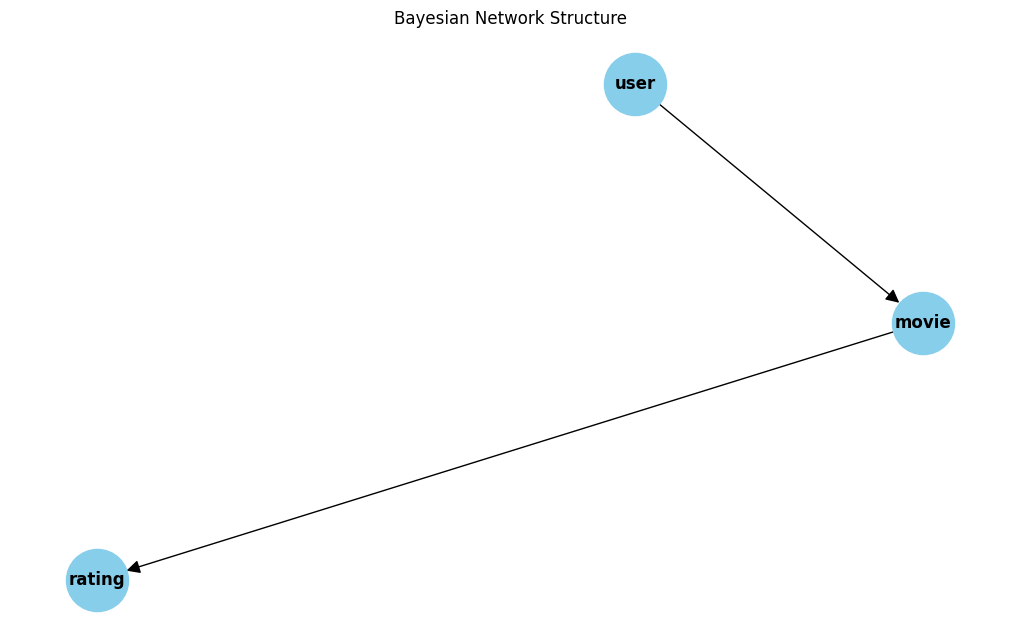

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a NetworkX graph from the Bayesian Network
nx_graph = nx.DiGraph()  # Create a directed graph

# Add nodes and edges from the Bayesian Network model
nx_graph.add_nodes_from(model.nodes())
nx_graph.add_edges_from(model.edges())

# Draw the NetworkX graph with custom settings
plt.figure(figsize=(10, 6))
nx.draw(nx_graph, with_labels=True, node_size=2000, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
plt.title("Bayesian Network Structure")
plt.show()


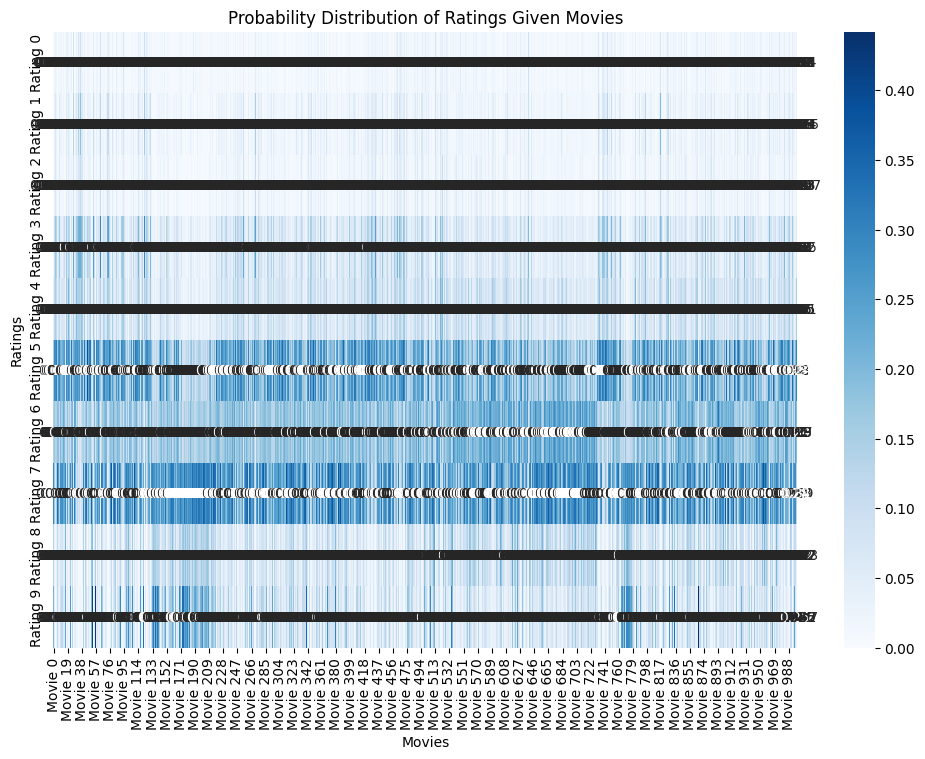

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the CPD for 'rating' to a DataFrame
rating_cpd = cpd_rating.get_values()
rating_df = pd.DataFrame(rating_cpd, columns=[f"Movie {i}" for i in range(rating_cpd.shape[1])], index=[f"Rating {i}" for i in range(rating_cpd.shape[0])])

# Create a heatmap to visualize the probability distribution of ratings given movies
plt.figure(figsize=(12, 8))
sns.heatmap(rating_df, annot=True, cmap="Blues")
plt.title("Probability Distribution of Ratings Given Movies")
plt.xlabel("Movies")
plt.ylabel("Ratings")
plt.show()


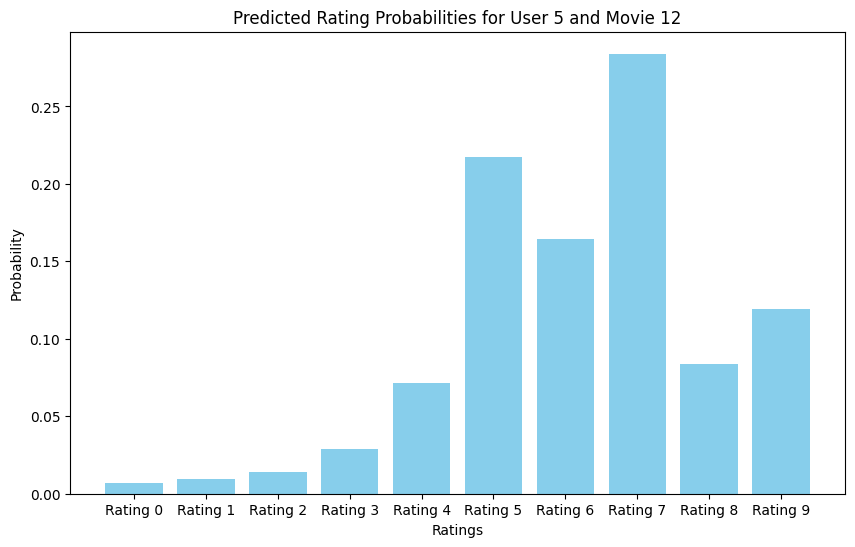

In [ ]:
# Perform inference and get the probability distribution of 'rating' given 'user' and 'movie'
query_result = infer.query(variables=['rating'], evidence={'user': 5, 'movie': 12})

# Extract the probabilities from the query result
ratings = [f'Rating {i}' for i in range(len(query_result.values))]
probabilities = query_result.values

# Create a bar plot for the predicted rating probabilities
plt.figure(figsize=(10, 6))
plt.bar(ratings, probabilities, color='skyblue')
plt.title("Predicted Rating Probabilities for User 5 and Movie 12")
plt.xlabel("Ratings")
plt.ylabel("Probability")
plt.show()


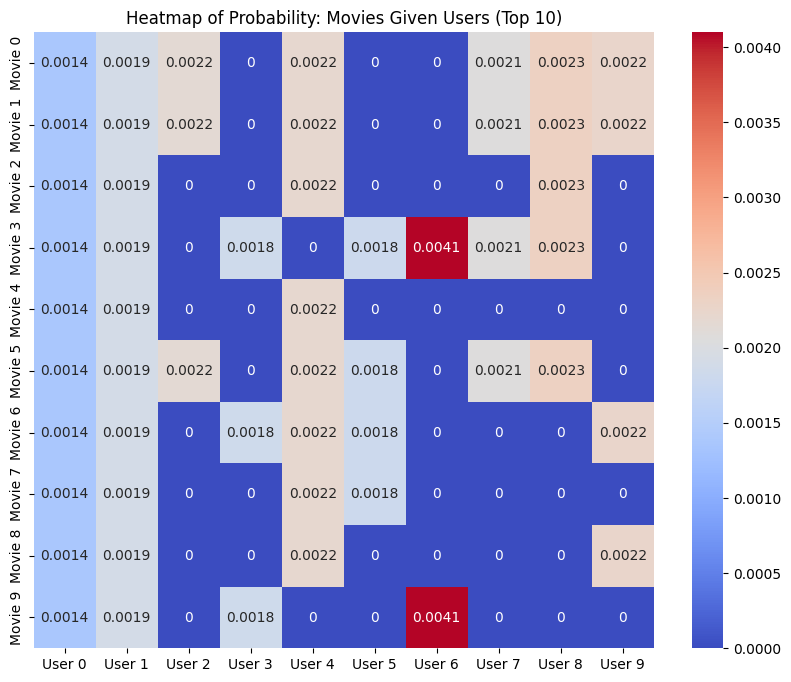

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

movie_given_user_cpd = pd.DataFrame(
    prob_movie_given_user,
    columns=[f"User {i}" for i in range(prob_movie_given_user.shape[1])],
    index=[f"Movie {i}" for i in range(prob_movie_given_user.shape[0])]
)


limited_movie_given_user_cpd = movie_given_user_cpd.iloc[:10, :10]  # Top 10 movies and top 10 users

# Plot heatmap for the top 10 users and movies
plt.figure(figsize=(10, 8))
sns.heatmap(limited_movie_given_user_cpd, cmap='coolwarm', annot=True)
plt.title("Heatmap of Probability: Movies Given Users (Top 10)")
plt.show()


# **STREAMLIT**

In [ ]:
!pip install pyngrok

In [ ]:
!ngrok authtoken 2nsQS5eUSgfiEwNn8fuL9Djn6SU_2DK49nbMWAL4LR5T1w5FT


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


 kill all the running ngrok processes

In [ ]:
!kill $(ps aux | grep ngrok | awk '{print $2}')


/bin/bash: line 1: kill: (13410) - No such process


In [ ]:
streamlit_code = """
import streamlit as st
import pandas as pd
import pickle
from pgmpy.inference import VariableElimination

# Load the trained model from the file
with open('bayesian_network_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Initialize inference
infer = VariableElimination(model)

# Create sliders for user and movie selection
user_id = st.slider('Select User ID', 0, 1000, 5)
movie_id = st.slider('Select Movie ID', 0, 1000, 12)

# Query the Bayesian Network with the selected values
query_result = infer.query(variables=['rating'], evidence={'user': user_id, 'movie': movie_id})

# Define actual rating values (instead of 0-9 index)
rating_values = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]

# Extract probabilities from query_result
probabilities = query_result.values

# Create a DataFrame with the correct rating values and their respective probabilities
probabilities_df = pd.DataFrame({
    'Rating': rating_values,
    'Probability': probabilities
})

# Plot the bar chart
st.bar_chart(probabilities_df.set_index('Rating')['Probability'])
"""

# Open a file named 'varEliminate_MovieDataset.py' in write mode
with open('varEliminate_MovieDataset.py', 'w') as f:
    f.write(streamlit_code)

import os
import threading
from pyngrok import ngrok

# Function to run Streamlit in a separate thread
def run_streamlit():
    os.system('streamlit run varEliminate_MovieDataset.py')  # This runs the Streamlit app you saved earlier

# Start Streamlit in a separate thread
thread = threading.Thread(target=run_streamlit)
thread.start()

# Expose the Streamlit app using ngrok
public_url = ngrok.connect(8501)  # Ensure the port is 8501
print(f"Streamlit app is running at: {public_url}")


Streamlit app is running at: NgrokTunnel: "https://b76a-35-227-142-183.ngrok-free.app" -> "http://localhost:8501"
